In [39]:
import sys
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import itertools
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

# Get current working directory and go up one level to project root
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.llm_application import LLMAccountant, row2doc, doc2lancamento

In [50]:
df = pd.read_csv("../data/input_com_categorias.csv")
knowledge_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [54]:
houldout_df, dev_df = train_test_split(test_df, test_size=0.8, random_state=42)

In [55]:
k_range = range(3, 15)
threshold_range = [i/10 for i in range(5, 10)]
grid = list(itertools.product(k_range, threshold_range))

In [56]:
dev_df

,Data,Descrição da Transação,Valor,Conta Contábil
55,25/02/2025,Táxi para compromisso - Cliente importante,70.0,Despesa - Deslocamento
15,16/01/2025,Combustível veículo empresa - Posto Shell,180.0,Despesa - Combustível
140,21/05/2025,Postagem de correspondência - ECT,15.0,Despesa - Correios e Malotes
142,23/05/2025,Anúncio em revista especializada - Revista Tech,600.0,Despesa - Marketing e Publicidade
56,26/02/2025,Vale-alimentação funcionários - Sodexo,1500.0,Despesa - Benefícios a Funcionários
115,26/04/2025,Plano odontológico funcionários - OdontoPrev,400.0,Despesa - Benefícios a Funcionários
41,11/02/2025,Despesas com lixo e reciclagem - Cia. Coleta,80.0,Despesa - Despesas Administrativas
60,02/03/2025,Resma de papel A4 - Kalunga,80.0,Despesa - Materiais de Escritório
100,11/04/2025,Materiais de limpeza para banheiro - Limpa Tudo,75.0,Despesa - Materiais de Limpeza
69,11/03/2025,Materiais para copa - Padaria Pão Quente,65.0,Despesa - Materiais de Consumo


In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for k, threshold in grid:
    accuracy_buffer = []
    for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(dev_df, dev_df['Conta Contábil'])):
        train_fold = dev_df.iloc[train_idx]
        val_fold = dev_df.iloc[val_idx]

        accountant = LLMAccountant(threshold=threshold, k=k)
        train_docs = [row2doc(row) for row in train_fold.iterrows()]
        accountant.add_source_of_truth(train_docs)

        val_docs = [row2doc(row) for row in val_fold.iterrows()]
        val_lancamentos = [doc2lancamento(doc) for doc in val_docs]

        output = accountant.batch(val_lancamentos)

        y_pred = [out['category'].category for out in output]
        y = val_fold['Conta Contábil']
        accuracy_buffer.append(accuracy_score(y, y_pred))

    break

In [ ]:
accuracy_buffer

In [23]:
accountant = LLMAccountant(threshold=0.5, k=3)
train_docs = [row2doc(row) for row in train_df.iterrows()]
accountant.add_source_of_truth(train_docs)

In [24]:
test_docs = [row2doc(row) for row in test_df.iterrows()]
test_lancamentos = [doc2lancamento(doc) for doc in test_docs]

In [25]:
output = accountant.batch(test_lancamentos)

In [26]:
len(test_df)

55

In [27]:
len(['a' for out in output if out['categorized_by_llm']])

44

In [28]:
y_pred = [out['category'].category for out in output]
y = test_df['Conta Contábil']

In [29]:
print(classification_report(y, y_pred))

                                         precision    recall  f1-score   support

                      Despesa - Aluguel       1.00      1.00      1.00         3
    Despesa - Assinaturas e Publicações       0.00      0.00      0.00         1
    Despesa - Benefícios a Funcionários       1.00      0.50      0.67         4
                  Despesa - Combustível       1.00      1.00      1.00         2
           Despesa - Correios e Malotes       1.00      1.00      1.00         2
                 Despesa - Deslocamento       0.67      1.00      0.80         2
     Despesa - Despesas Administrativas       0.00      0.00      0.00         1
             Despesa - Eventos e Feiras       0.00      0.00      0.00         0
                          Despesa - Gás       0.00      0.00      0.00         1
             Despesa - Impostos e Taxas       1.00      1.00      1.00         1
                     Despesa - Internet       1.00      0.50      0.67         2
           Despesa - Manute

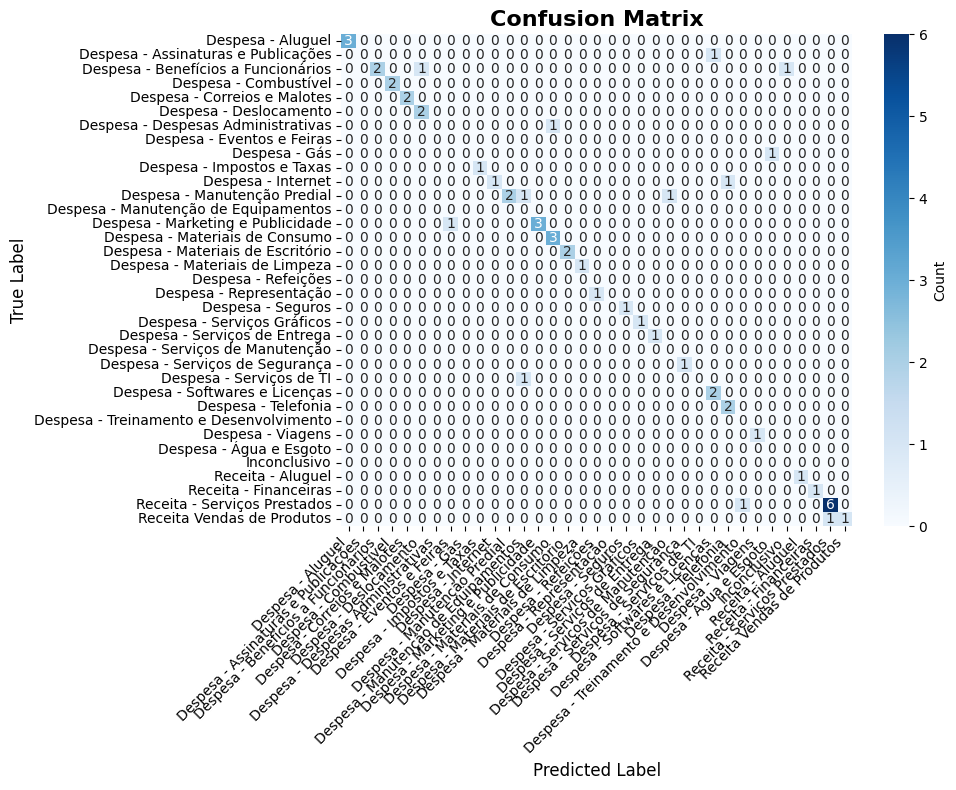


Accuracy: 0.7636


In [30]:
# Calculate confusion matrix
cm = confusion_matrix(y, y_pred)

# Get unique labels for proper ordering
labels = sorted(list(set(y) | set(y_pred)))

# Create the plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print accuracy
from sklearn.metrics import accuracy_score
print(f"\nAccuracy: {accuracy_score(y, y_pred):.4f}")